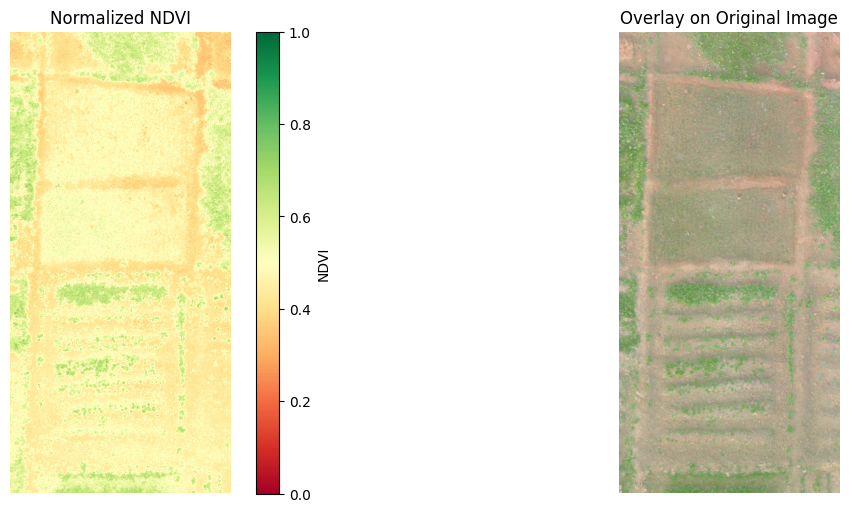

In [14]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------- MODEL DEFINITION --------------------
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear1 = nn.Linear(3, 6)
        self.linear2 = nn.Linear(6, 10)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

# -------------------- LOAD STATE DICT --------------------
model = MyModel()
state_dict = torch.load("ndvi_gopro.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# -------------------- LOAD IMAGE --------------------
img = cv2.imread("Arducam 2025-10-11 Ortho.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img.shape

# Flatten image for vectorized inference
img_norm = img.astype(np.float32) / 255.0
flat = img_norm.reshape(-1, 3)

# -------------------- EXTRACT WEIGHTS --------------------
w1 = model.linear1.weight.detach().numpy()
b1 = model.linear1.bias.detach().numpy()
w2 = model.linear2.weight.detach().numpy()
b2 = model.linear2.bias.detach().numpy()
w3 = model.linear3.weight.detach().numpy()
b3 = model.linear3.bias.detach().numpy()

# -------------------- VECTORIZE INFERENCE --------------------
batch_size = 1024 * 16
out_list = []
for i in range(0, flat.shape[0], batch_size):
    batch = flat[i:i+batch_size]
    h1 = batch @ w1.T + b1
    h2 = h1 @ w2.T + b2
    pred = h2 @ w3.T + b3
    out_list.append(pred)

out = np.concatenate(out_list, axis=0)
ndvi_map = out.reshape(h, w)

# -------------------- DISPLAY --------------------
# Normalize NDVI between 0 and 1
ndvi_norm = (ndvi_map - np.min(ndvi_map)) / (np.max(ndvi_map) - np.min(ndvi_map))

# Generate colormap: diverging RdYlGn (red = low, green = high)
colormap = plt.get_cmap('RdYlGn')
heatmap = colormap(ndvi_norm)[:, :, :3]  # remove alpha
heatmap = (heatmap * 255).astype(np.uint8)

# Overlay heatmap on original image
overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Display
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].imshow(ndvi_norm, cmap='RdYlGn')
axes[0].set_title('Normalized NDVI')
axes[0].axis('off')

axes[1].imshow(overlay)
axes[1].set_title('Overlay on Original Image')
axes[1].axis('off')

plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=axes[0], fraction=0.046, pad=0.04, label='NDVI')
plt.show()
